In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S
from holotomocupy.tomo import R, RT
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import linear, dai_yuan
import sys

%matplotlib inline
# !jupyter nbconvert --to script rec_reprojection_codes.ipynb

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension

ntheta = 360  # number of angles (rotations)
noise = 0
z1c = -12e-3
# thickness of the coded aperture
code_thickness = 1.5e-6 #in m
# feature size
ill_feature_size = 1e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction


center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles
npos = 1  # number of code positions
detector_pixelsize = 3e-6/2
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

# magnification when propagating from the probe plane to the detector
magnifications2 = np.abs(z1/z1c)
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'{n}_{ntheta}_{npos}_{z1c}_{noise}_code'
# print(magnifications2,norm_magnifications)
# print(distances2,distances22)

## Read data

In [3]:
data00 = np.zeros([ntheta, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'/data2/vnikitin/coded_apertures_new3/data/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'/data2/vnikitin/coded_apertures_new3/data/data_{k}_{flg}.tiff')[:ntheta]
for k in range(npos):
    ref0[:, k] = read_tiff(f'/data2/vnikitin/coded_apertures_new3/data/ref_{k}_{flg}.tiff')[:]
code = np.load(f'/data2/vnikitin/coded_apertures_new3/data/code_{flg}.npy')
shifts_code = np.load(f'/data2/vnikitin/coded_apertures_new3/data/shifts_code_{flg}.npy')[:, :npos]

# code = np.pad(code,((0,0),(ne//2,ne//2),(ne//2,ne//2)),'edge')
print(code.shape)

/data2/vnikitin/coded_apertures_new3/data/data_0_256_360_1_-0.012_0_code.tiff
(1, 640, 640)


# Construct operators


In [4]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        coder = cp.tile(code, [psi.shape[0], 1, 1])
        
        # shift and crop the code 
        coder = S(coder, shifts_code[:, i])
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]

        # multiply by the probe
        coder *= prbr

        # propagate both to the sample plane
        coder = G(coder, wavelength, voxelsize, distances2[i])
        
        # multiply by the sample
        psir *= coder           

        # propagate all to the detector
        psir = G(psir, wavelength, voxelsize, distances[i])

        # unpad
        data[:, i] = psir[:, psir.shape[1]//2-n//2:psir.shape[1]//2+n//2, psir.shape[1]//2-n//2:psir.shape[1]//2+n//2]
    return data

@gpu_batch
def _adj_holo(data, shifts_code, prb, code):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        prbr = cp.tile(prb,[psi.shape[0],1,1])        
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        psir = GT(psir, wavelength, voxelsize, distances[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]        
        coder *= prbr
        coder = G(coder, wavelength, voxelsize, distances2[j])
        psir *= cp.conj(coder)
        psi += psir
    return psi

@gpu_batch
def _adj_holo_prb(data, shifts_code, psi, code):
    psi = cp.array(psi)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)       
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = psi.copy()
        prbr = GT(prbr, wavelength, voxelsize, distances[j])
        prbr*=cp.conj(psir)
        prbr = GT(prbr, wavelength, voxelsize, distances2[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]
        prbr *= cp.conj(coder)
        prb += prbr
    return prb

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)
def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, prb, code)
def adj_holo_prb(data, psi):
    ''' Adjoint Holography operator '''
    return np.sum(_adj_holo_prb(data, shifts_code, psi, code), axis=0)[np.newaxis]

# adjoint tests
data = data00.copy()
arr1 = cp.pad(cp.array(data[:, 0]+1j*data[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')

prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
code = cp.array(code)
shifts_code = cp.array(shifts_code)
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(prb1*cp.conj(arr4))}==\n{cp.sum(arr2*cp.conj(arr2))}')

arr1 = arr1.swapaxes(0,1)
a = RT(arr1,theta,ne//2)
b = R(a,theta,ne//2)
c = RT(b,theta,ne//2)
print(f'{cp.sum(arr1*cp.conj(b))}==\n{cp.sum(a*cp.conj(a))}')
print(f'{cp.sum(a*cp.conj(a))}==\n{cp.sum(a*cp.conj(c))}')

(46541132-0.2093353271484375j)==
(46541136+3.1990544812288135e-05j)
(46541128-0.478515625j)==
(46541136+3.1990544812288135e-05j)
(69306848+3.0418059825897217j)==
(69306848-0.0005910028703510761j)
(69306848-0.0005910028703510761j)==
(70047712-2.113626718521118j)


### Propagate the code to the detector and divide all data by it

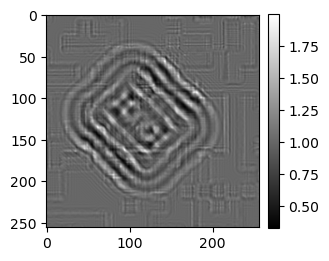

In [5]:
psi = cp.ones([ntheta,ne,ne],dtype='complex64')
prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
ref0 = cp.array(ref0)
data00 = cp.array(data00)
d = cp.abs(fwd_holo(psi,prb))**2

rdata = data00/d/ref0
mshow((rdata)[0,0],show)

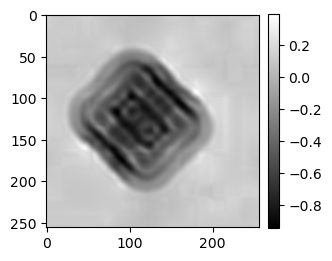

In [6]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:npos]
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances_pag, wavelength, voxelsize,  100, 1e-12))
mshow(np.angle(recMultiPaganin[0]),show)

#### Exponential and logarithm functions for the Transmittance function

In [7]:

def exptomo(psi):
    """Exp representation of projections"""
    return np.exp(1j*psi * voxelsize * 2*cp.pi / wavelength*np.sqrt(3*ne//2*ntheta))

def logtomo(psi):
    """Log representation of projections, -i/\nu log(psi)"""
    res = psi.copy()
    res[np.abs(psi) < 1e-32] = 1e-32
    res = np.log(res)
    res = -1j * wavelength / (2*cp.pi) * res / voxelsize/np.sqrt(3*ne//2*ntheta)
    return res

# Operators for the flat field

In [8]:
@gpu_batch
def _fwd_holo0(prb):
    data = cp.zeros([1, npos, n, n], dtype='complex64')
    for j in range(npos):
        # propagate illumination
        data[:, j] = G(prb, wavelength, voxelsize, distances[0])[:, pad:n+pad, pad:n+pad]
    return data

def fwd_holo0(prb):
    return _fwd_holo0(prb)

@gpu_batch
def _adj_holo0(data):
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        # ill shift for each acquisition
        prbr = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += prbr
    return prb

def adj_holo0(data):
    return _adj_holo0(data)


# adjoint test
data = data[0, :].copy()
ref = ref0.copy()
prb1 = cp.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = cp.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)

print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(131381.859375-0.004475720226764679j)==
(131381.859375-1.0811481843120418e-06j)


# ADMM

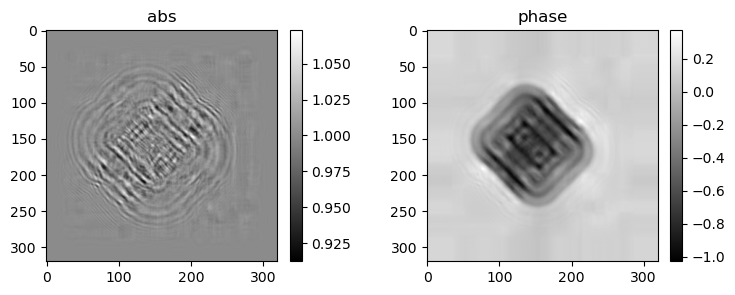

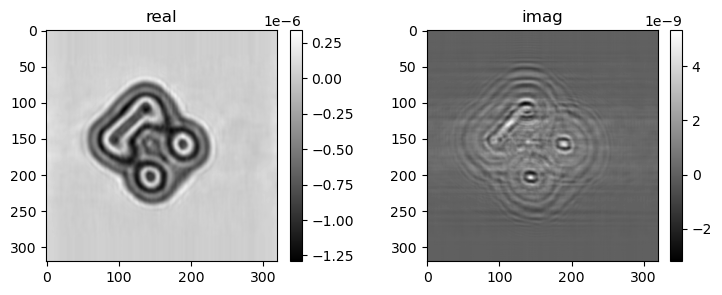

15701.029296875
0/100) rho=0.500000, 2.01e+03 8.39e+04 4.20e+04, Sum: 1.28e+05, err: 1.279e+05
15701.029296875
1/100) rho=0.500000, 5.06e+03 6.69e+03 3.89e+04, Sum: 5.07e+04, err: 5.068e+04
15701.029296875
2/100) rho=0.500000, 7.80e+03 6.37e+03 7.17e+02, Sum: 1.49e+04, err: 1.489e+04
15701.029296875
3/100) rho=0.500000, 1.01e+04 4.87e+03 3.23e+02, Sum: 1.53e+04, err: 1.526e+04
15701.029296875
4/100) rho=0.500000, 1.16e+04 3.73e+03 1.58e+02, Sum: 1.55e+04, err: 1.548e+04


KeyboardInterrupt: 

In [9]:
def line_search_ext(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd,fu0+gamma*fd0) < 0 and gamma > 1e-2):
        gamma *= 0.5
    if(gamma <= 1e-2):  # direction not found        
        gamma = 0
    return gamma

def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-3):
        gamma *= 0.5
    if(gamma <= 1e-3):  # direction not found
        #print(f'{fu.shape} r no direction')
        gamma = 0
    return gamma

# def update_penalty(psi, h, h0, rho):
    # rho
    r = cp.linalg.norm(psi - h)**2
    s = cp.linalg.norm(rho*(h-h0))**2
    if (r > 10*s):
        rho *= 2
    elif (s > 10*r):
        rho *= 0.5
    return rho

def cg_holo_ext(data, init_psi, init_prb, h, lamd, rho, pars):
    """Conjugate gradients method for holography"""
    # minimization functional    
    @gpu_batch
    def _minf(fpsi,data, psi, h, lamd, rho):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = cp.linalg.norm(cp.abs(fpsi[k])-data[k])**2        
            res[k] += rho*cp.linalg.norm(h[k]-psi[k]+lamd[k]/rho)**2  
        return res
    
    def minf(fpsi,psi):
        res = np.sum(_minf(fpsi,data, psi, h, lamd, rho))        
        return res    
     
    @gpu_batch
    def _minfprb(fpsi,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = cp.linalg.norm(cp.abs(fpsi[k])-data[k])**2        
        return res
    
    def minfprb(fpsi):
        res = np.sum(_minfprb(fpsi,data))        
        return res    
    
    psi = init_psi.copy()
    prb = init_prb.copy()

    for i in range(pars['hiter']):
        fpsi = fwd_holo(psi,prb)
        grad = adj_holo(fpsi-data*np.exp(1j*np.angle(fpsi)),prb)/npos

        # mshow(data[0,0],mshow)
        # mshow_polar(fpsi[0,0],mshow)
        # mshow_polar((data*np.exp(1j*np.angle(fpsi)))[0,0],mshow)
        # mshow_polar((fpsi-data*np.exp(1j*np.angle(fpsi)))[0,0],mshow)
        # mshow_polar(grad[0],mshow)
        grad += -rho*(h - psi + lamd/rho)
        
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)
        grad0 = grad

        # line search
        fd = fwd_holo(d,prb)
        gamma = line_search_ext(minf, pars['gammapsi'], fpsi, psi, fd, d)
        psi += gamma*d        

        if pars['upd_prb']:
            fpsi = fwd_holo(psi,prb)        
            gradprb = adj_holo_prb(fpsi-data*np.exp(1j*np.angle(fpsi)),psi)/ntheta        
            if i == 0:
                dprb = -gradprb
            else:
                dprb = dai_yuan(dprb,gradprb,gradprb0)
            gradprb0 = gradprb
            fd = fwd_holo(psi,dprb)
            gammaprb = line_search(minfprb, pars['gammaprb'], fpsi, fd)
            # print(f"{i} {gammaprb=}")
            prb += gammaprb*dprb
        
    return psi,prb

def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional    
    @gpu_batch
    def _minf(Ru,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(Ru[k]-data[k])**2
        return res
    
    def minf(Ru):
        res = np.sum(_minf(Ru,data))
        return res
    
    u = init.copy()
    center_pad = u.shape[-1]//2
    for i in range(pars['titer']):
        fu = R(u,theta,center_pad)
        grad = RT(fu-data,theta,center_pad)#/np.float32(np.prod(data.shape[1:]))
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)

        grad0 = grad
        fd = R(d, theta, center_pad)
        gamma = line_search(minf, pars['gammau'], fu, fd)
        u = linear(u,d,1,gamma)   
        # print('t',i,minf(R(u,theta,center_pad)))
    return u

def take_lagr_gpu(psi, prb, data, h, lamd,rho):
    lagr = np.zeros(4, dtype="float32")
    fpsi = fwd_holo(psi,prb)    
    lagr[0] = np.linalg.norm(np.abs(fpsi)-data)**2            
    lagr[1] = 2*np.sum(np.real(np.conj(lamd)*(h-psi)))    
    lagr[2] = rho*np.linalg.norm(h-psi)**2    
    lagr[3] = np.sum(lagr[0:3])    
    return lagr

def admm(data, psi, prb, h, lamd, u, pars):
    # if exist then load and comment the above
    u0 = np.load('data/u.npy').astype('complex64')
    u0 = cp.array(np.pad(u0,((pad,pad),(pad,pad),(pad,pad))))
    rho = 0.5
    data = np.sqrt(data)
    err = cp.zeros([pars['niter'],2])
    for m in range(pars['niter']):
        # keep previous iteration for penalty updates
        psi, prb = cg_holo_ext(data, psi, prb, h, lamd, rho, pars)
        
        xi = logtomo(psi-lamd/rho)        
        # xi = np.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')
        xi = xi.swapaxes(0,1)
        
        u = cg_tomo(xi, u, pars)
        # h update
        Ru = R(u,theta,u.shape[-1]//2).swapaxes(0,1)
        h = exptomo(Ru)
        
        # lambda update
        lamd += rho * (h-psi)        

        if m%pars['vis_step']==0:# or m<64:
            mshow_polar(psi[0],show)            
            mshow_complex(u[:,ne//2+3],show)            
            # mshow_complex(u[:,ne//2+3]-u0[:,ne//2+3,:],show)            
            # mshow_polar(prb[0],show)         
            # dxchange.write_tiff(u.real.get(),f'/data2/vnikitin/coded_apertures_new3/ur_{flg}/{m:03}.tiff',overwrite=True)
            # dxchange.write_tiff(u[:,ne//2+ne//4+3,ne//4:-ne//4].real.get(),f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff',overwrite=True)
            #dxchange.write_tiff(cp.angle(psi).get(),f'/data2/vnikitin/coded_apertures_new3/psi_{flg}/{m:03}.tiff',overwrite=True)
            
            
        # Lagrangians difference between two iterations
        if m%pars['err_step']==0:            
            lagr = take_lagr_gpu(psi, prb, data, h, lamd,rho)
            err[m,0] = lagr[0]
            err[m,1] = lagr[-1]#cp.linalg.norm(u[:,ne//4:-ne//4,ne//4:-ne//4]-u0)**2/cp.linalg.norm(u0)**2
            
            eR = exptomo(R(u,theta,u.shape[-1]//2).swapaxes(0,1))
            Lpsi = fwd_holo(eR,prb)
            err[m,0] = np.linalg.norm(np.abs(Lpsi)-data)**2   
            print(err[m,0])
            print("%d/%d) rho=%f, %.2e %.2e %.2e, Sum: %.2e, err: %.3e" %(m, pars['niter'], rho, *lagr, err[m,1]))
            np.save(f'/data2/vnikitin/coded_apertures_new3/conv_{flg}',err.get())
        
    return u, psi, err

#holo initial guess
psirec = cp.pad(cp.array(recMultiPaganin),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')

#tomo initial guess
xi = logtomo(psirec).swapaxes(0,1)
# xi = cp.pad(xi,((0,0),(0,0),(ne//4,ne//4)),'edge')#[ne,3*ne//2,3*ne//2],dtype='complex64')
urec = cp.zeros([ne,ne,ne],dtype='complex64')
pars = {'titer':65, 'gammau':0.5}
urec = cg_tomo(xi,urec,pars)

#lamd and h
lamd = cp.zeros([ntheta,ne,ne],dtype='complex64')
h  = psirec.copy()
data = cp.array(data00)
# rec_prb = cp.array(rec_prb0)
# prb initial guess
# urec[:] = 0
# psirec[:] = 1
# h[:] = 1
rec_prb = np.load(f'/data2/vnikitin/coded_apertures_new3/data/prb_{flg}.npy')
# admm
pars = {'niter': 512, 'titer': 4, 'hiter':4, 'err_step': 1, 'vis_step': 16, 
        'gammapsi': 0.5,'gammaprb': 0.5, 'gammau': 0.5, 'upd_prb': False}
urec, psirec,err = admm(data, psirec, rec_prb, h, lamd, urec, pars)

k = f'admmline'
np.save(f'data/u_{k}_{pars['niter']}',urec.get())
np.save(f'data/conv_{k}',err[:,0])
np.save(f'data/step_{k}',err[:,1])